In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importar bibliotecas del sistema
import os              # Proporciona funciones para interactuar con el sistema operativo.
import time            # Proporciona funciones relacionadas con el tiempo.
import shutil          # Proporciona funciones para operaciones de archivo y directorio.
import pathlib         # Proporciona clases para manipular rutas de archivo y directorio.
import itertools       # Proporciona funciones para crear iteradores.

# importar herramientas de manipulación de datos
import cv2             # Proporciona funciones para leer y manipular imágenes.
import numpy as np     # Proporciona funciones para manipulación de matrices y operaciones numéricas.
import pandas as pd    # Proporciona estructuras de datos y funciones para el análisis de datos.
import seaborn as sns  # Proporciona estilos visuales para gráficos.
sns.set_style('darkgrid')  # Establece el estilo visual de los gráficos.
import matplotlib.pyplot as plt  # Proporciona funciones para trazar gráficos y visualizaciones.
from sklearn.model_selection import train_test_split  # Proporciona funciones para dividir conjuntos de datos en entrenamiento y prueba.
from sklearn.metrics import confusion_matrix, classification_report  # Proporciona funciones para calcular métricas de evaluación de modelos.

# importar bibliotecas de aprendizaje profundo
import tensorflow as tf  # Proporciona un entorno para construir y entrenar modelos de aprendizaje profundo.
from tensorflow import keras  # Proporciona una API de alto nivel para construir y entrenar modelos de aprendizaje profundo.
from tensorflow.keras.models import Sequential  # Proporciona una interfaz para crear modelos secuenciales.
from tensorflow.keras.optimizers import Adam, Adamax  # Proporciona optimizadores para ajustar los pesos del modelo.
from tensorflow.keras.metrics import categorical_crossentropy  # Proporciona una métrica para evaluar el rendimiento del modelo.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Proporciona herramientas para la generación de imágenes aumentadas.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization  # Proporciona capas para construir el modelo de aprendizaje profundo.
from tensorflow.keras import regularizers  # Proporciona regularizadores para controlar el sobreajuste del modelo.

# Ignorar las advertencias
import warnings
warnings.filterwarnings("ignore")

print('módulos cargados')

módulos cargados


VGG19 ENTRENAMIENTO_PASO PREVIO

# *recorrer el directorio que contiene los archivos de imágenes, obtener las rutas y las almacenarlas(etiquetar) *

In [4]:
# Generar rutas de archivos con etiquetas
def definir_rutas(directorio_datos):
  rutas_archivos = [] # Lista para almacenar las rutas de los archivos
  etiquetas = [] # Lista para almacenar las etiquetas
  carpetas = os.listdir(directorio_datos)  # Obtener la lista de carpetas en el directorio de datos
  for carpeta in carpetas:
      ruta_carpeta = os.path.join(directorio_datos, carpeta)  # Obtener la ruta completa de la carpeta
      # Verificar si hay otros archivos en el directorio principal. Si los hay, se ignoran.
      if pathlib.Path(ruta_carpeta).suffix != '':
          continue

      lista_archivos = os.listdir(ruta_carpeta)  # Obtener la lista de archivos en la carpeta
      for archivo in lista_archivos:
          ruta_archivo = os.path.join(ruta_carpeta, archivo)  # Obtener la ruta completa del archivo

          # Verificar si hay otras carpetas
          if pathlib.Path(ruta_carpeta).suffix == '':
              # Verificar las máscaras no deseadas
              if pathlib.Path(ruta_archivo).parts[-1] == 'masks' or pathlib.Path(ruta_archivo).parts[-1] == 'Masks' or pathlib.Path(ruta_archivo).parts[-1] == 'MASKS':
                  continue

              else:
                  archivos_subcarpeta = os.listdir(ruta_archivo)  # Obtener la lista de archivos en la subcarpeta
                  for archivo_subcarpeta in archivos_subcarpeta:
                      ruta_archivo_subcarpeta = os.path.join(ruta_archivo, archivo_subcarpeta)  # Obtener la ruta completa del archivo
                      rutas_archivos.append(ruta_archivo_subcarpeta)  # Agregar la ruta del archivo a la lista
                      etiquetas.append(carpeta)  # Agregar la etiqueta a la lista

          else:
              rutas_archivos.append(ruta_archivo)  # Agregar la ruta del archivo a la lista
              etiquetas.append(carpeta)  # Agregar la etiqueta a la lista

  return rutas_archivos, etiquetas


In [5]:
# Concatenar las rutas de los datos con las etiquetas en un dataframe (para luego ser ajustado en el modelo)
def definir_df(archivos, clases):
  serie_rutas = pd.Series(archivos, name='rutas_archivos') # Crear una serie con las rutas de los archivos
  serie_etiquetas = pd.Series(clases, name='etiquetas') # Crear una serie con las etiquetas
  return pd.concat([serie_rutas, serie_etiquetas], axis=1) # Concatenar las series en un dataframe

In [6]:
# Dividir el dataframe en conjuntos de entrenamiento, validación y prueba
def dividir_datos(directorio_datos):
  # Obtener el dataframe de entrenamiento
  archivos, clases = definir_rutas(directorio_datos) # Obtener las rutas de los archivos y las etiquetas
  df = definir_df(archivos, clases) # Crear el dataframe con las rutas y etiquetas
  etiquetas_estratificadas = df['etiquetas'] # Definir la columna de etiquetas para el muestreo estratificado
  df_entrenamiento, df_restante = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=etiquetas_estratificadas) # Dividir el dataframe en entrenamiento y el resto (df_restante)

  # Obtener los dataframes de validación y prueba
  etiquetas_estratificadas = df_restante['etiquetas']  # Definir la columna de etiquetas para el muestreo estratificado
  df_validacion, df_prueba = train_test_split(df_restante, train_size=0.5, shuffle=True, random_state=123, stratify=etiquetas_estratificadas)  # Dividir el dataframe df_restante en validación y prueba

  return df_entrenamiento, df_validacion, df_prueba

VGG19 ENTRENAMIENTO

In [7]:
def crear_generadores_entrenamiento_validacion_prueba(df_entrenamiento, df_validacion, df_prueba, tam_lote):
    '''
    Esta función toma los dataframes de entrenamiento, validación y prueba, y los ajusta en generadores de datos de imágenes,
    ya que el modelo toma los datos de un generador de datos de imágenes. El generador de datos de imágenes convierte las imágenes en tensores.
    '''

    # Definir los parámetros del modelo
    tam_img = (224, 224)
    canales = 3  # puede ser BGR o escala de grises
    color = 'rgb'
    forma_img = (tam_img[0], tam_img[1], canales)

    # Recomendado: usar una función personalizada para el tamaño del lote de datos de prueba, de lo contrario, podemos usar el tamaño de lote normal.
    longitud_prueba = len(df_prueba) # Calcula el número de muestras en el conjunto de datos de prueba

    # Calcula el tamaño óptimo del lote para el conjunto de datos de prueba.
    # Se busca el divisor más grande de longitud_prueba que sea menor o igual a 80.
    # Esto es útil para asegurar que el tamaño del lote se ajuste bien a la cantidad de datos disponibles.
    tam_lote_prueba = max(sorted([longitud_prueba // n for n in range(1, longitud_prueba + 1) if longitud_prueba % n == 0 and longitud_prueba / n <= 80]))

    # Calcula el número de pasos necesarios para procesar todos los datos de prueba en lotes de tamaño tam_lote_prueba
    pasos_prueba = longitud_prueba // tam_lote_prueba

    # Esta función se utilizará en el generador de datos de imágenes para la ampliación de datos. Simplemente toma la imagen y la devuelve.
    def escalar(img):
        return img

    # Crea un generador de datos de imagen para el conjunto de entrenamiento con ampliación de datos (volteo horizontal).
    # Utiliza la función de preprocesamiento personalizada 'escalar'.
    generador_entrenamiento = ImageDataGenerator(preprocessing_function=escalar, horizontal_flip=True)

    # Crea un generador de datos de imagen para el conjunto de validación y prueba.
    # No se aplica ampliación de datos en estos conjuntos.
    generador_validacion_prueba = ImageDataGenerator(preprocessing_function=escalar)

    # Configura el generador de datos de entrenamiento con las rutas de las imágenes, etiquetas, tamaño de imagen y tamaño de lote.
    generador_entrenamiento = generador_entrenamiento.flow_from_dataframe(df_entrenamiento, x_col='rutas_archivos', y_col='etiquetas', target_size=tam_img, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=tam_lote)

    # Configura el generador de datos de validación de manera similar al de entrenamiento.
    generador_validacion = generador_validacion_prueba.flow_from_dataframe(df_validacion, x_col='rutas_archivos', y_col='etiquetas', target_size=tam_img, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=tam_lote)

    # Configura el generador de datos de prueba. Nota que shuffle=False para mantener el orden de las muestras.
    # Se utiliza un tamaño de lote personalizado calculado previamente.
    generador_prueba = generador_validacion_prueba.flow_from_dataframe(df_prueba, x_col='rutas_archivos', y_col='etiquetas', target_size=tam_img, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=tam_lote_prueba)

    # Devuelve los generadores de datos de entrenamiento, validación y prueba.
    return generador_entrenamiento, generador_validacion, generador_prueba


In [8]:
def mostrar_imagenes(generador):
    '''
    Esta función toma el generador de datos y muestra una muestra de las imágenes.
    '''

    # Obtiene las clases e imágenes que se mostrarán
    diccionario_generador = generador.class_indices  # define el diccionario {'clase': índice}
    clases = list(diccionario_generador.keys())  # define una lista de las claves del diccionario (clases), nombres de las clases: string
    imagenes, etiquetas = next(generador)  # obtiene una muestra de tamaño de lote del generador

    # Calcula el número de muestras a mostrar
    longitud = len(etiquetas)  # longitud del tamaño de lote
    muestra = min(longitud, 25)  # verifica si hay menos de 25 imágenes en la muestra

    plt.figure(figsize=(20, 20))

    for i in range(muestra):
        plt.subplot(5, 5, i + 1)
        imagen = imagenes[i] / 255  # escala los datos al rango (0 - 255)
        plt.imshow(imagen)
        indice = np.argmax(etiquetas[i])  # obtiene el índice de la imagen
        nombre_clase = clases[indice]  # obtiene la clase de la imagen
        plt.title(nombre_clase, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [ ]:
#FUNCION CALLBACK: PUEDE OPTIMIZAR , DETENER Y CONTROLAR EL ENTRENAMIENTO

In [9]:
class MiCallback(keras.callbacks.Callback):
    def __init__(self, modelo, paciencia, paciencia_para_detener, umbral, factor, lotes, epocas, preguntar_epoca):
        super(MiCallback, self).__init__()
        self.modelo = modelo
        self.paciencia = paciencia  # especifica cuántas épocas sin mejora antes de ajustar la tasa de aprendizaje
        self.paciencia_para_detener = paciencia_para_detener  # especifica cuántas veces ajustar la lr sin mejora para detener el entrenamiento
        self.umbral = umbral  # especifica el umbral de precisión de entrenamiento cuando se ajustará la lr en función de la pérdida de validación
        self.factor = factor  # factor por el cual reducir la tasa de aprendizaje
        self.lotes = lotes  # número de lotes de entrenamiento que se ejecutarán por época
        self.epocas = epocas
        self.preguntar_epoca = preguntar_epoca
        self.preguntar_epoca_inicial = preguntar_epoca  # guarda este valor para restaurarlo si se reinicia el entrenamiento

        # variables de callback
        self.contador = 0  # cuántas veces se ha reducido la lr sin mejora
        self.contador_para_detener = 0
        self.mejor_epoca = 1  # época con la pérdida más baja
        self.tasa_aprendizaje_inicial = float(tf.keras.backend.get_value(modelo.optimizer.lr))  # obtiene la tasa de aprendizaje inicial y la guarda
        self.prec_tr_entrenamiento_mas_alta = 0.0  # establece la precisión de entrenamiento más alta inicialmente en 0.0
        self.perd_val_mas_baja = np.inf  # establece la pérdida de validación más baja inicialmente en infinito
        self.mejores_pesos = self.modelo.get_weights()  # establece los mejores pesos en los pesos iniciales del modelo
        self.pesos_iniciales = self.modelo.get_weights()  # guarda los pesos iniciales si es necesario restaurarlos

    # Define una función que se ejecutará al comienzo del entrenamiento
    def on_train_begin(self, logs=None):
        # Pregunta al usuario si desea que el modelo solicite permiso para detener el entrenamiento
        msg = '¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?'
        print(msg)
        ans = input('')
        # Si el usuario responde 's' o 'S', establece la variable ask_permission en 1
        if ans in ['S', 's']:
            self.pedir_permiso = 1
        # Si el usuario responde 'n' o 'N', establece la variable ask_permission en 0
        elif ans in ['N', 'n']:
            self.pedir_permiso = 0

        # Imprime los encabezados de las columnas para el registro de entrenamiento
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Época', 'Pérdida', 'Precisión', 'Pérdida_V', 'Precisión_V', 'LR', 'Siguiente LR', 'Monitor','% Mejora', 'Duración')
        print(msg)
        # Guarda el tiempo actual para calcular la duración del entrenamiento más adelante
        self.tiempo_inicio = time.time()

    # Define una función que se ejecutará al final del entrenamiento
    def on_train_end(self, logs=None):
        # Guarda el tiempo actual
        tiempo_final = time.time()
        # Calcula la duración total del entrenamiento en segundos
        duracion_entrenamiento = tiempo_final - self.tiempo_inicio
        # Convierte la duración a horas, minutos y segundos
        horas = duracion_entrenamiento // 3600
        minutos = (duracion_entrenamiento - (horas * 3600)) // 60
        segundos = duracion_entrenamiento - ((horas * 3600) + (minutos * 60))

        # Imprime la duración del entrenamiento en horas, minutos y segundos
        msg = f'tiempo transcurrido durante el entrenamiento: {str(horas)} horas, {minutos:4.1f} minutos, {segundos:4.2f} segundos)'
        print(msg)

        # Establece los pesos del modelo a los mejores pesos encontrados durante el entrenamiento
        self.modelo.set_weights(self.mejores_pesos)

    # Define una función que se ejecutará al final de cada lote de entrenamiento
    def on_train_batch_end(self, batch, logs=None):
        # Obtiene la precisión y la pérdida del lote actual y las multiplica por 100 para convertirlas en porcentajes
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # Imprime la precisión y la pérdida del lote actual en la misma línea
        # Esto crea una especie de barra de progreso en la consola
        msg = '{0:20s}procesando lote {1:} de {2:5s} - precisión= {3:5.3f} - pérdida: {4:8.5f}'.format(' ', str(batch), str(self.lotes), acc, loss)
        print(msg, '\r', end='')


    # Definimos el método que se ejecutará al final de cada época
    def on_epoch_end(self, epoch, logs=None):
        # Guarda el tiempo actual para calcular la duración de la época
        self.tiempo_final = time.time()
        duracion = self.tiempo_final - self.tiempo_inicio

        lr = float(tf.keras.backend.get_value(self.modelo.optimizer.lr)) # obtener la tasa de aprendizaje actual
        tasa_aprendizaje_actual = lr
        acc = logs.get('accuracy')  # obtener la precisión del entrenamiento
        v_acc = logs.get('val_accuracy')  # obtener la precisión de validación
        loss = logs.get('loss')  # obtener la pérdida de entrenamiento para esta época
        v_loss = logs.get('val_loss')  # obtener la pérdida de validación para esta época

        if acc < self.umbral: # si la precisión del entrenamiento está por debajo del umbral, ajustar lr en función de la precisión del entrenamiento
            monitor = 'precisión' # Establece la variable de monitoreo en 'precisión' para indicar que se está monitoreando la precisión de entrenamiento

            # Si es la primera época, establece la mejora del progreso en 0
            if epoch == 0:
                mejora_progreso = 0.0

            # De lo contrario, calcula el porcentaje de mejora en la precisión de entrenamiento en comparación con la época anterior
            else:
                mejora_progreso = (acc - self.prec_tr_entrenamiento_mas_alta) * 100 / self.prec_tr_entrenamiento_mas_alta # definir la mejora del progreso del modelo


            if acc > self.prec_tr_entrenamiento_mas_alta: # Si la precisión de entrenamiento ha mejorado en esta época
                self.prec_tr_entrenamiento_mas_alta = acc # # Actualiza la precisión de entrenamiento más alta con el valor actual
                self.mejores_pesos = self.modelo.get_weights() # la precisión del entrenamiento mejoró, así que guardar los pesos
                self.contador = 0 # establecer el contador en 0 ya que la precisión del entrenamiento mejoró
                self.contador_para_detener = 0 # establecer el contador de parada en 0

                # Si la pérdida de validación es menor que la pérdida de validación más baja registrada, actualiza la pérdida de validación más baja
                if v_loss < self.perd_val_mas_baja:
                    self.perd_val_mas_baja = v_loss
                self.mejor_epoca = epoch + 1  # establecer el valor de la mejor época para esta época

            else:
                # En este bloque, la precisión del entrenamiento no mejoró en la época actual.

                # Verifica si la precisión del entrenamiento no ha mejorado durante un número específico de épocas ('paciencia').
                # Si es así, es hora de ajustar la tasa de aprendizaje.
                if self.contador >= self.paciencia - 1:
                    # Ajusta la tasa de aprendizaje multiplicándola por un factor (generalmente un valor entre 0 y 1).
                    lr = lr * self.factor

                    # Establece la nueva tasa de aprendizaje en el optimizador del modelo.
                    tf.keras.backend.set_value(self.modelo.optimizer.lr, lr)

                    # Restablece el contador de épocas sin mejora a 0, ya que acabamos de ajustar la tasa de aprendizaje.
                    self.contador = 0

                    # Incrementa el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                    self.contador_para_detener = self.contador_para_detener + 1

                    # Si la pérdida de validación es menor que la pérdida de validación más baja registrada, actualiza la pérdida de validación más baja.
                    if v_loss < self.perd_val_mas_baja:
                        self.perd_val_mas_baja = v_loss
                else:
                    # La precisión del entrenamiento no mejoró, pero aún no hemos alcanzado el límite de 'paciencia'.
                    # Incrementa el contador de épocas sin mejora.
                    self.contador = self.contador + 1


        else:
            # En este bloque, la precisión del entrenamiento está por encima de un umbral predefinido,
            # por lo que ajustaremos la tasa de aprendizaje en función de la pérdida de validación.

            # Establece la variable de monitoreo en 'val_loss' para indicar que se está monitoreando la pérdida de validación.
            monitor = 'val_loss'

            # Si es la primera época, establece la mejora del progreso en 0.
            if epoch == 0:
                mejora_progreso = 0.0
            # De lo contrario, calcula el porcentaje de mejora en la pérdida de validación en comparación con la época anterior.
            else:
                mejora_progreso = (self.perd_val_mas_baja - v_loss) * 100 / self.perd_val_mas_baja

            # Si la pérdida de validación ha mejorado en esta época.
            if v_loss < self.perd_val_mas_baja:
                # Actualiza la pérdida de validación más baja con el valor actual.
                self.perd_val_mas_baja = v_loss

                # Guarda los pesos del modelo, ya que la pérdida de validación ha mejorado.
                self.mejores_pesos = self.modelo.get_weights()

                # Restablece el contador de épocas sin mejora a 0, ya que hubo una mejora en esta época.
                self.contador = 0

                # Restablece el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                self.contador_para_detener = 0

                # Actualiza la mejor época con la época actual (las épocas están indexadas desde 1).
                self.mejor_epoca = epoch + 1
            else:
                # La pérdida de validación no mejoró.

                # Verifica si la pérdida de validación no ha mejorado durante un número específico de épocas ('paciencia').
                # Si es así, es hora de ajustar la tasa de aprendizaje.
                if self.contador >= self.paciencia - 1:
                    # Ajusta la tasa de aprendizaje multiplicándola por un factor (generalmente un valor entre 0 y 1).
                    lr = lr * self.factor

                    # Incrementa el contador de ajustes de tasa de aprendizaje realizados consecutivamente sin mejoras.
                    self.contador_para_detener = self.contador_para_detener + 1

                    # Restablece el contador de épocas sin mejora a 0, ya que acabamos de ajustar la tasa de aprendizaje.
                    self.contador = 0

                    # Establece la nueva tasa de aprendizaje en el optimizador del modelo.
                    tf.keras.backend.set_value(self.modelo.optimizer.lr, lr)
                else:
                    # La pérdida de validación no mejoró, pero aún no hemos alcanzado el límite de 'paciencia'.
                    # Incrementa el contador de épocas sin mejora.
                    self.contador = self.contador + 1

                # Si la precisión del entrenamiento es mayor que la precisión más alta registrada, actualiza la precisión más alta.
                if acc > self.prec_tr_entrenamiento_mas_alta:
                    self.prec_tr_entrenamiento_mas_alta = acc


        # Formatea y muestra un mensaje con información sobre la época actual, incluyendo pérdida, precisión, tasa de aprendizaje, etc.
        msg = f'{str(epoch + 1):^3s}/{str(self.epocas):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{tasa_aprendizaje_actual:^9.5f}{lr:^9.5f}{monitor:^11s}{mejora_progreso:^10.2f}{duracion:^8.2f}'
        print(msg)

        # Verifica si la tasa de aprendizaje se ha ajustado 'paciencia_para_detener' veces sin mejoras.
        if self.contador_para_detener > self.paciencia_para_detener - 1:
            # Si es así, muestra un mensaje indicando que el entrenamiento se detendrá.
            msg = f'El entrenamiento ha sido detenido en la época {epoch + 1} después de {self.paciencia_para_detener} ajustes de tasa de aprendizaje sin mejora'
            print(msg)

            # Detiene el entrenamiento.
            self.modelo.stop_training = True
        else:
            # Si el usuario ha configurado 'preguntar_epoca' y ha dado permiso para preguntar, verifica si se ha alcanzado la época especificada.
            if self.preguntar_epoca is not None and self.pedir_permiso != 0:
                if epoch + 1 >= self.preguntar_epoca:
                    # Pregunta al usuario si desea detener el entrenamiento o continuar durante un número específico de épocas.
                    msg = 'Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente'
                    print(msg)

                    # Recibe la entrada del usuario.
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        # Si el usuario ingresa 'H' o 'h', detiene el entrenamiento y muestra un mensaje.
                        msg = f'El entrenamiento ha sido detenido en la época {epoch + 1} debido a la entrada del usuario'
                        print(msg)
                        self.modelo.stop_training = True
                    else:
                        # Si el usuario ingresa un número, establece la nueva época en la que se preguntará nuevamente.
                        try:
                            ans = int(ans)
                            self.preguntar_epoca += ans
                            msg = f'El entrenamiento continuará hasta la época {str(self.preguntar_epoca)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Época', 'Pérdida', 'Precisión', 'Pérdida_V', 'Precisión_V', 'LR', 'Siguiente LR', 'Monitor', '% Mejora', 'Duración')
                            print(msg)
                        except Exception:
                            # Si la entrada no es válida, muestra un mensaje de error.
                            print('Entrada no válida')


In [10]:
#trazar el historial de precisión y pérdidas, mostrando la mejor época en ambos
def plot_training(hist):
    '''
    Esta función toma el modelo de entrenamiento y traza el historial de precisión y pérdidas con la mejor época en ambos.
    '''

    # Definir variables necesarias
    tr_acc = hist.history['accuracy']    # Precisión de entrenamiento en cada época
    tr_loss = hist.history['loss']       # Pérdida de entrenamiento en cada época
    val_acc = hist.history['val_accuracy']    # Precisión de validación en cada época
    val_loss = hist.history['val_loss']       # Pérdida de validación en cada época
    index_loss = np.argmin(val_loss)    # Índice de la pérdida de validación más baja
    val_lowest = val_loss[index_loss]   # Valor de la pérdida de validación más baja
    index_acc = np.argmax(val_acc)      # Índice de la precisión de validación más alta
    acc_highest = val_acc[index_acc]    # Valor de la precisión de validación más alta
    Epochs = [i+1 for i in range(len(tr_acc))]    # Lista de épocas (1, 2, 3, ...)
    loss_label = f'mejor epoca= {str(index_loss + 1)}'   # Etiqueta para la mejor época de pérdida
    acc_label = f'mejor epoca= {str(index_acc + 1)}'     # Etiqueta para la mejor época de precisión

    # Graficar el historial de entrenamiento
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Perdida del Entrenmaiento')    # Gráfico de pérdida de entrenamiento
    plt.plot(Epochs, val_loss, 'g', label= 'Perdida en la validacion')  # Gráfico de pérdida de validación
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)   # Punto de la mejor época de pérdida
    plt.title('Perdida del Entrenamiento y Perdida de Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Precision del Entrenamiento')   # Gráfico de precisión de entrenamiento
    plt.plot(Epochs, val_acc, 'g', label= 'Precision de la validacion') # Gráfico de precisión de validación
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)    # Punto de la mejor época de precisión
    plt.title('Precision del Entrenamiento y la Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()    # Ajustar el diseño de los subgráficos
    plt.show()


In [11]:
##Matriz de confusion
def trazar_matriz_confusion(matriz_confusion, clases, normalizar=False, titulo='Matriz de Confusión', cmap=plt.cm.Blues):
    '''
    Esta función traza la matriz de confusión.
    Puede mostrar la matriz de confusión en forma normalizada o sin normalizar.
    '''

    # Crea una figura de tamaño 10x10.
    plt.figure(figsize=(10, 10))

    # Muestra los datos como una imagen; es decir, en un mapa de colores regular.
    plt.imshow(matriz_confusion, interpolation='nearest', cmap=cmap)

    # Agrega un título a la figura.
    plt.title(titulo)

    # Agrega una barra de colores a la figura.
    plt.colorbar()

    # Define las marcas de graduación en los ejes x e y.
    marcas = np.arange(len(clases))

    # Agrega las etiquetas de clase a los ejes x e y.
    plt.xticks(marcas, clases, rotation=45)
    plt.yticks(marcas, clases)

    # Normaliza la matriz de confusión dividiendo cada fila por la suma de esa fila si normalizar=True.
    if normalizar:
        matriz_confusion = matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis]
        print('Matriz de Confusión Normalizada')
    else:
        print('Matriz de Confusión, Sin Normalizar')

    # Imprime la matriz de confusión en la consola.
    print(matriz_confusion)

    # Establece el umbral para el color del texto en las celdas de la matriz de confusión.
    umbral = matriz_confusion.max() / 2.

    # Itera sobre cada celda de la matriz de confusión y agrega el valor de la celda como texto.
    for i, j in itertools.product(range(matriz_confusion.shape[0]), range(matriz_confusion.shape[1])):
        plt.text(j, i, matriz_confusion[i, j],
                 horizontalalignment="center",
                 color="white" if matriz_confusion[i, j] > umbral else "black")

    # Ajusta el diseño para que todo encaje en la figura.
    plt.tight_layout()

    # Etiqueta los ejes.
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')


*Resultados*

In [12]:
#leer datos
data_dir = '/content/drive/MyDrive/Procesamiento_QuispeLopez/Unidad 2/Los Pollos/IMGDataset/'

try:
    # Obtener los conjuntos de datos divididos
    df_entrenamiento, df_validacion, df_prueba = dividir_datos(data_dir)

    # Obtener los generadores
    tam_lote =4
    generador_entrenamiento, generador_validacion, generador_prueba = crear_generadores_entrenamiento_validacion_prueba(df_entrenamiento, df_validacion, df_prueba, tam_lote)

except:
    print('Entrada Inválida')


Found 74 validated image filenames belonging to 2 classes.
Found 9 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.


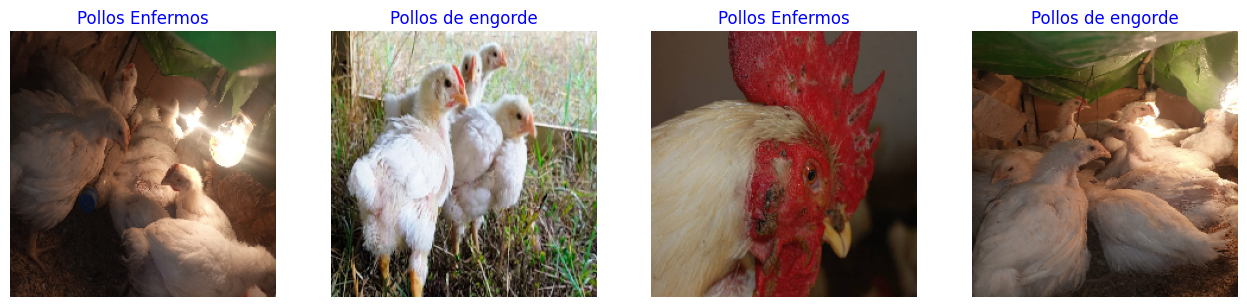

In [13]:
mostrar_imagenes(generador_entrenamiento)

**MODELO VGG19**

In [14]:
# Crear la estructura del modelo
tamaño_img = (224, 224)
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
# En este caso, utilizaremos VGG19 como modelo base.
modelo_base_VGG19 = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_VGG19 = Sequential([
    modelo_base_VGG19,
    Dense(cantidad_clases, activation='softmax')
])

modelo_VGG19.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_VGG19.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_________________________________________________________________


**MODELO DENSENET169**

In [15]:
# Crear la estructura del modelo
tamaño_img = (224, 224)
canales = 3
forma_img = (tamaño_img[0], tamaño_img[1], canales)
cantidad_clases = len(list(generador_entrenamiento.class_indices.keys()))  # para definir el número de clases en la capa densa

# Crear el modelo pre-entrenado (puedes construirlo sobre un modelo pre-entrenado como EfficientNet, VGG, ResNet)
# En este caso, utilizaremos DenseNet169 como modelo base.
modelo_base_DenseNet169 = tf.keras.applications.densenet.DenseNet169(include_top=False, weights="imagenet", input_shape=forma_img, pooling='max')

modelo_DenseNet169 = Sequential([
    modelo_base_DenseNet169,
    Dense(cantidad_clases, activation='softmax')
])

modelo_DenseNet169.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

modelo_DenseNet169.summary()


51877672/51877672 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense_1 (Dense)             (None, 2)                 3330      
                                                                 
Total params: 12,646,210
Trainable params: 12,487,810
Non-trainable params: 158,400
_________________________________________________________________


ENTRENAMIENTO DEL MODELO VGG19

In [16]:
#parametros callback
tam_lote = 16 # Establecer el tamaño del lote para el entrenamiento
epocas = 5 # Número total de épocas en el entrenamiento
paciencia = 3 # Número de épocas a esperar para ajustar la tasa de aprendizaje si el valor monitoreado no mejora
paciencia_para_detener = 2 # Número de épocas a esperar antes de detener el entrenamiento si el valor monitoreado no mejora
umbral_entrenamiento = 0.9 # Si la precisión del entrenamiento es < umbral, ajustar el valor monitoreado de precisión; de lo contrario, monitorear la pérdida de validación
factor_reduccion = 0.5 # Factor para reducir la tasa de aprendizaje
preguntar_epoca = 5 # Número de épocas para ejecutar antes de preguntar si deseas detener el entrenamiento
lotes_entrenados = int(np.ceil(len(generador_entrenamiento.labels) / tam_lote)) # Número de lotes de entrenamiento para ejecutar por época

callbacks = [MiCallback(modelo=modelo_VGG19, paciencia=paciencia, paciencia_para_detener=paciencia_para_detener, umbral=umbral_entrenamiento,
factor=factor_reduccion, lotes=lotes_entrenados, epocas=epocas, preguntar_epoca=preguntar_epoca)]

In [17]:
history_VGG19 = modelo_VGG19.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5     230.200  58.108   0.61179  66.667   0.00100  0.00100  precisión    0.00    41.33  
 2 /5      0.627   68.919   0.61690  66.667   0.00100  0.00100  precisión   18.60    45.45  
 3 /5      0.618   68.919   0.62446  66.667   0.00100  0.00100  precisión    0.00    48.21  
 4 /5      0.597   68.919   0.63523  66.667   0.00100  0.00100  precisión    0.00    53.36  
 5 /5      0.604   68.919   0.61475  66.667   0.00100  0.00050  precisión    0.00    56.53  
Ingresa H para detener el entrenamiento o un número para continuar durante un número específico de épocas y luego preguntar nuevamente
8
El entrenamiento continuará hasta la época 13
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
tiempo transcurrido durante el entrenamiento: 0.0 horas,  1.0 minutos, 39.42 segundos)


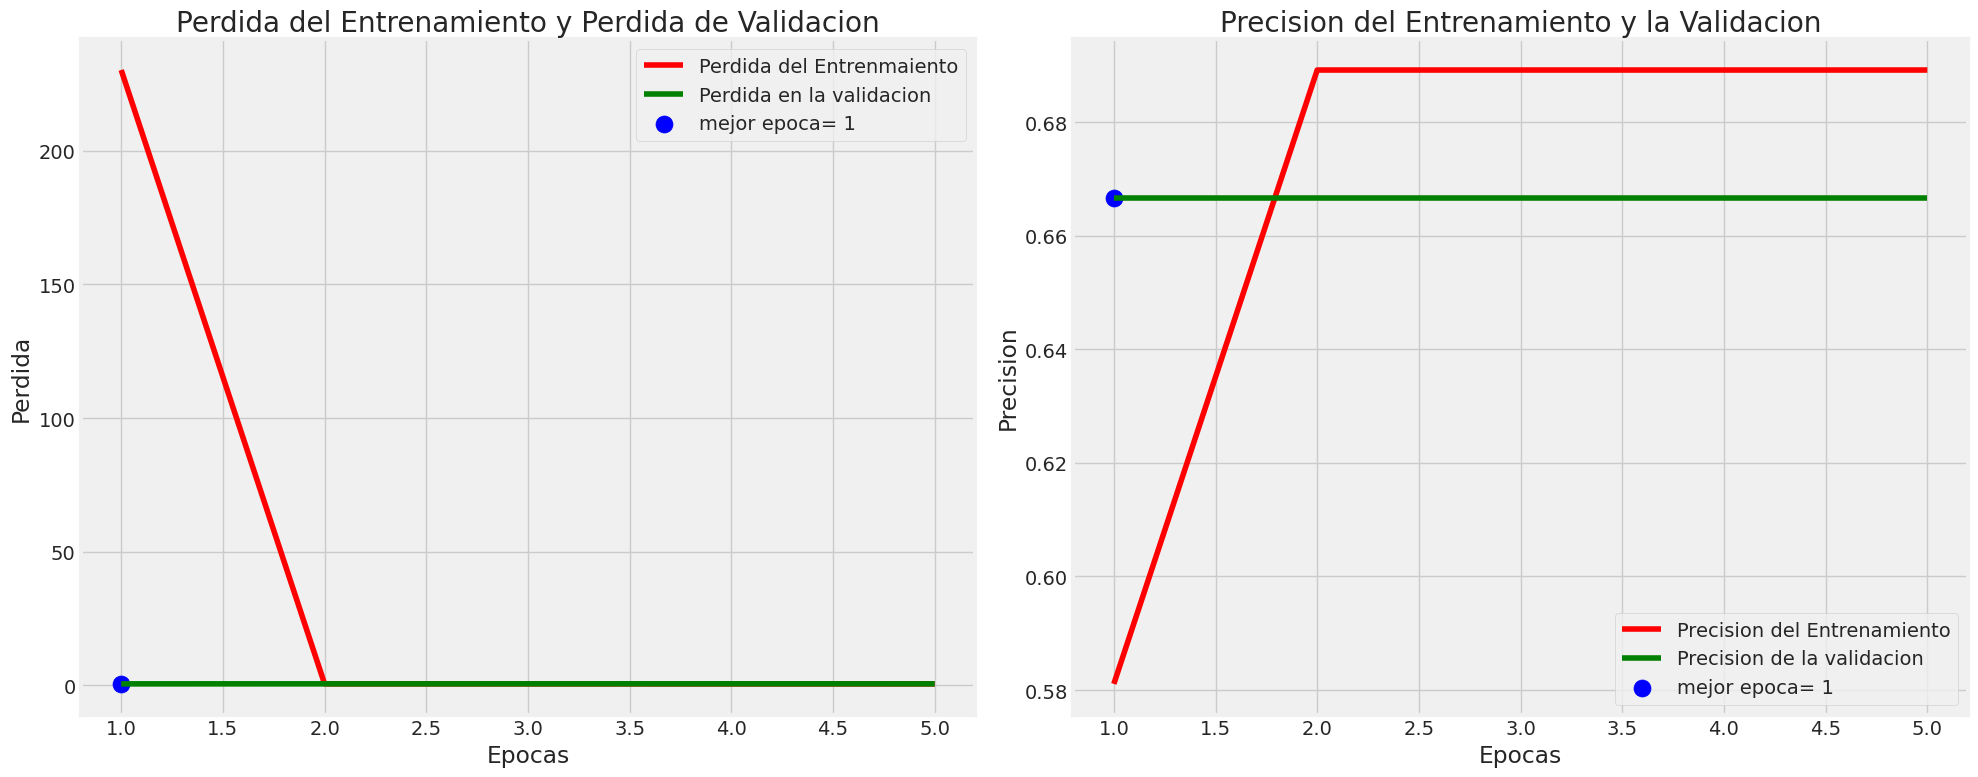

In [18]:
plot_training(history_VGG19)

In [23]:
history_DenseNet169 = modelo_DenseNet169.fit(x=generador_entrenamiento, epochs=epocas, verbose=0, callbacks=callbacks, validation_data=generador_validacion, validation_steps=None, shuffle=False)

¿Deseas que el modelo te pida que detengas el entrenamiento [s/n]?
s
 Época   Pérdida  PrecisiónPérdida_VPrecisión_V   LR    Siguiente LR Monitor  % Mejora  Duración
 1 /5      2.119   72.973  20.25738  55.556   0.00050  0.00050  precisión    0.00    105.36 
 2 /5      2.700   72.973   1.12760  77.778   0.00050  0.00050  precisión    0.00    108.83 
 3 /5      0.826   81.081   4.30028  55.556   0.00050  0.00050  precisión   11.11    113.67 
 4 /5      0.749   82.432   0.00002  100.000  0.00050  0.00050  precisión    1.67    120.49 
 5 /5      0.659   86.486  34.44634  33.333   0.00050  0.00050  precisión    4.92    123.61 
tiempo transcurrido durante el entrenamiento: 0.0 horas,  2.0 minutos, 3.66 segundos)


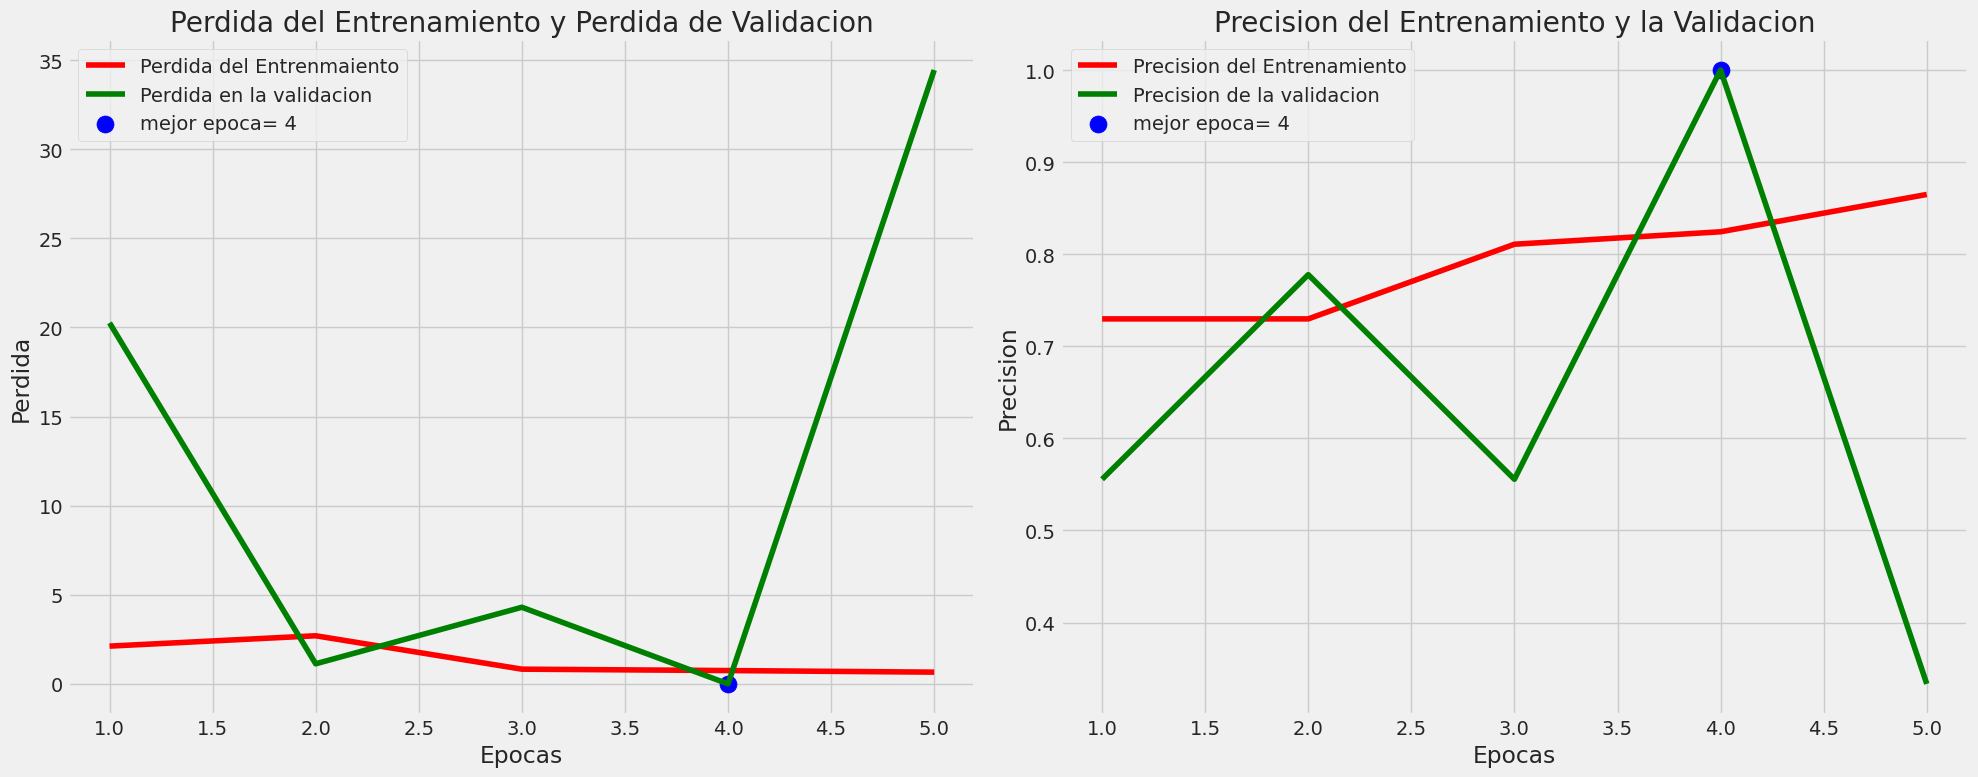

In [24]:
plot_training(history_DenseNet169)

In [25]:
ts_length = len(df_prueba)  # longitud del conjunto de datos de prueba
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# tamaño del lote para el conjunto de datos de prueba
test_steps = ts_length // test_batch_size  # número de pasos para ejecutar el conjunto de datos de prueba en el modelo

train_score = modelo_VGG19.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de entrenamiento
valid_score = modelo_VGG19.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de validación
test_score = modelo_VGG19.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de prueba

print("Pérdida en entrenamiento: ", train_score[0])  # mostrar la pérdida en el conjunto de datos de entrenamiento
print("Precisión en entrenamiento: ", train_score[1])  # mostrar la precisión en el conjunto de datos de entrenamiento
print('-' * 20)
print("Pérdida en validación: ", valid_score[0])  # mostrar la pérdida en el conjunto de datos de validación
print("Precisión en validación: ", valid_score[1])  # mostrar la precisión en el conjunto de datos de validación
print('-' * 20)
print("Pérdida en prueba: ", test_score[0])  # mostrar la pérdida en el conjunto de datos de prueba
print("Precisión en prueba: ", test_score[1])  # mostrar la precisión en el conjunto de datos de prueba


1/1 [==============================] - 0s 301ms/step - loss: 0.7203 - accuracy: 0.5000
Pérdida en entrenamiento:  0.5259041786193848
Precisión en entrenamiento:  0.75
--------------------
Pérdida en validación:  0.5835312604904175
Precisión en validación:  0.75
--------------------
Pérdida en prueba:  0.7203333377838135
Precisión en prueba:  0.5


In [26]:
ts_length = len(df_prueba)  # longitud del conjunto de datos de prueba
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
# tamaño del lote para el conjunto de datos de prueba
test_steps = ts_length // test_batch_size  # número de pasos para ejecutar el conjunto de datos de prueba en el modelo

train_score = modelo_DenseNet169.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de entrenamiento
valid_score = modelo_DenseNet169.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de validación
test_score = modelo_DenseNet169.evaluate(generador_entrenamiento, steps=test_steps, verbose=1)  # evaluar el modelo en el conjunto de datos de prueba

print("Pérdida en entrenamiento: ", train_score[0])  # mostrar la pérdida en el conjunto de datos de entrenamiento
print("Precisión en entrenamiento: ", train_score[1])  # mostrar la precisión en el conjunto de datos de entrenamiento
print('-' * 20)
print("Pérdida en validación: ", valid_score[0])  # mostrar la pérdida en el conjunto de datos de validación
print("Precisión en validación: ", valid_score[1])  # mostrar la precisión en el conjunto de datos de validación
print('-' * 20)
print("Pérdida en prueba: ", test_score[0])  # mostrar la pérdida en el conjunto de datos de prueba
print("Precisión en prueba: ", test_score[1])  # mostrar la precisión en el conjunto de datos de prueba


1/1 [==============================] - 0s 244ms/step - loss: 9.7847 - accuracy: 0.7500
Pérdida en entrenamiento:  15.253517150878906
Precisión en entrenamiento:  0.5
--------------------
Pérdida en validación:  25.887908935546875
Precisión en validación:  0.0
--------------------
Pérdida en prueba:  9.784700393676758
Precisión en prueba:  0.75


In [27]:
# Obtén las predicciones del modelo en el generador de datos de prueba
preds_VGG19 = modelo_VGG19.predict(generador_prueba)
y_pred_VGG19 = np.argmax(preds_VGG19, axis=1)  # Obtén las clases predichas (índice con mayor probabilidad) a partir de las predicciones
print(y_pred_VGG19)  # Imprimir las clases predichas

1/1 [==============================] - 0s 305ms/step
[1 1 1 1 1 1 1 1 1 1]


In [28]:
# Obtén las predicciones del modelo en el generador de datos de prueba
preds_DenseNet169 = modelo_DenseNet169.predict(generador_prueba)
y_pred_DenseNet169 = np.argmax(preds_DenseNet169, axis=1)  # Obtén las clases predichas (índice con mayor probabilidad) a partir de las predicciones
print(y_pred_DenseNet169)  # Imprimir las clases predichas

1/1 [==============================] - 5s 5s/step
[0 0 0 0 1 0 1 1 0 0]


Matriz de Confusión, Sin Normalizar
[[0 3]
 [0 7]]
Reporte de Clasificación para VGG19:
                   precision    recall  f1-score   support

  Pollos Enfermos       0.00      0.00      0.00         3
Pollos de engorde       0.70      1.00      0.82         7

         accuracy                           0.70        10
        macro avg       0.35      0.50      0.41        10
     weighted avg       0.49      0.70      0.58        10

Matriz de Confusión, Sin Normalizar
[[2 1]
 [5 2]]
Reporte de Clasificación para DenseNet169:
                   precision    recall  f1-score   support

  Pollos Enfermos       0.29      0.67      0.40         3
Pollos de engorde       0.67      0.29      0.40         7

         accuracy                           0.40        10
        macro avg       0.48      0.48      0.40        10
     weighted avg       0.55      0.40      0.40        10



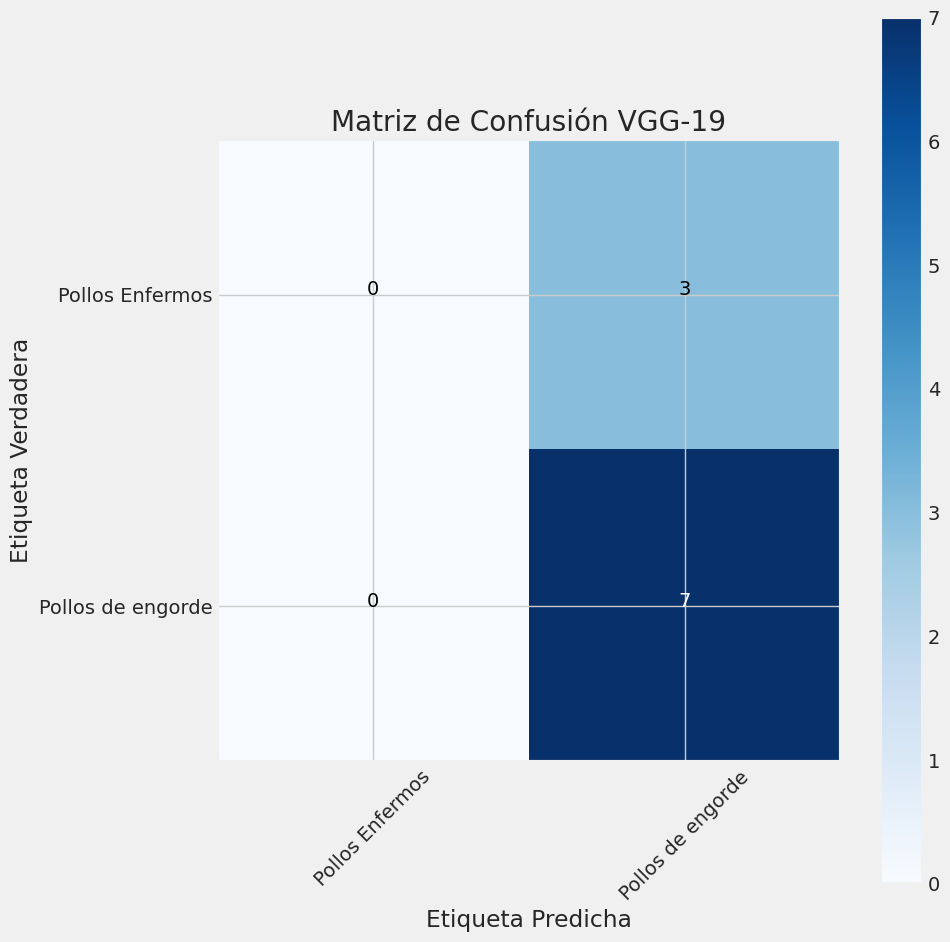

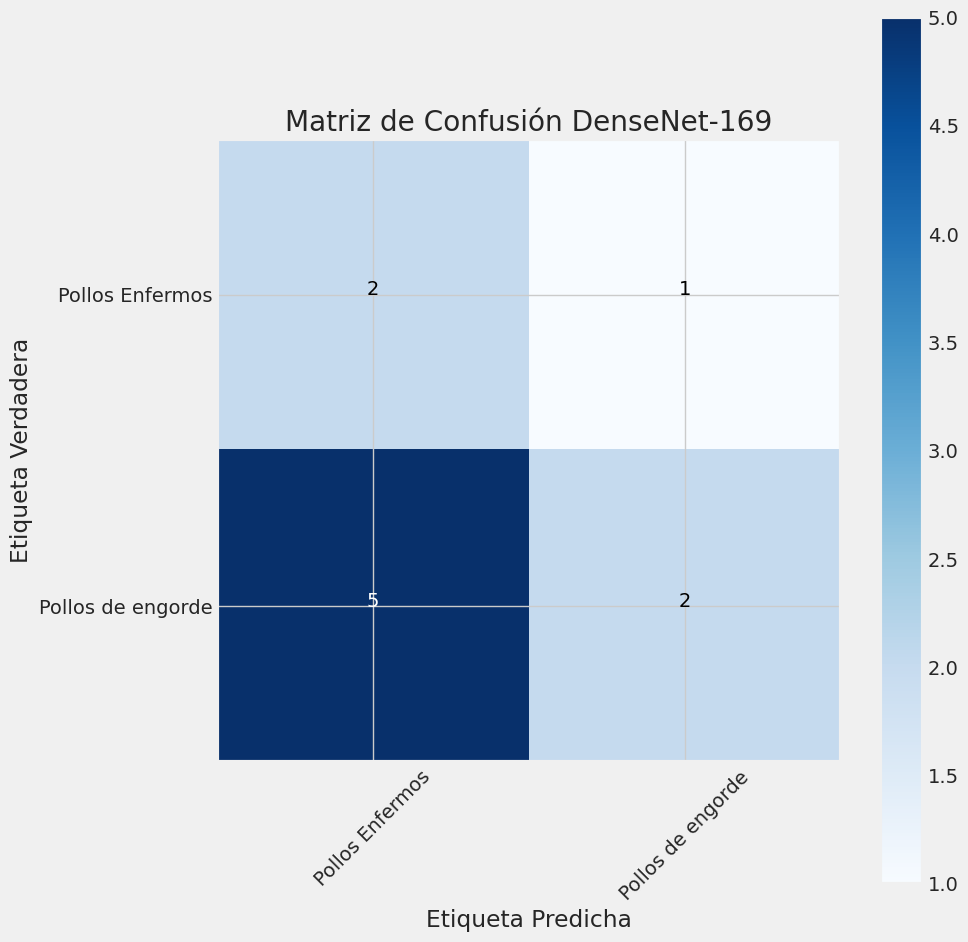

In [29]:
g_diccionario = generador_prueba.class_indices  # obtener el diccionario de índices de clases del generador de datos de prueba
clases = list(g_diccionario.keys())  # obtener la lista de nombres de clases a partir de las claves del diccionario

# Matriz de confusión
cm_VGG19 = confusion_matrix(generador_prueba.classes, y_pred_VGG19)  # calcular la matriz de confusión utilizando las clases reales y las clases predichas
trazar_matriz_confusion(matriz_confusion=cm_VGG19, clases=clases, titulo='Matriz de Confusión VGG-19')  # graficar la matriz de confusión

# Reporte de clasificación
print("Reporte de Clasificación para VGG19:")
print(classification_report(generador_prueba.classes, y_pred_VGG19, target_names=clases))  # imprimir el reporte de clasificación que incluye precision, recall, F1-score, y soporte para cada clase


# Matriz de confusión
cm_dense169 = confusion_matrix(generador_prueba.classes, y_pred_DenseNet169)  # calcular la matriz de confusión utilizando las clases reales y las clases predichas
trazar_matriz_confusion(matriz_confusion=cm_dense169, clases=clases, titulo='Matriz de Confusión DenseNet-169')  # graficar la matriz de confusión

# Reporte de clasificación
print("Reporte de Clasificación para DenseNet169:")
print(classification_report(generador_prueba.classes, y_pred_DenseNet169, target_names=clases))
